<a href="https://colab.research.google.com/github/georgian-io/constrained_optimization_workshop/blob/main/Constrained_Optimization_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook walks through solving a linear program and an integer program using Google OR-Tools.  
https://developers.google.com/optimization/mip/integer_opt

First, let's install Google OR-Tools

In [1]:
import numpy as np
import pandas as pd

# Runtime must restart before the package can be properly imported
try:
  from ortools.linear_solver import pywraplp
except (ImportError, KeyError, ModuleNotFoundError):
  !python -m pip install --upgrade --user ortools
  print('Stopping RUNTIME. Colaboratory will restart automatically. Please run again.')
  exit()

# The Diet Problem (Linear Version)
Given a variety type of food (beef, chicken, etc.) and their respective costs, nutritional values, and min and max amounts. The problem is to find a diet that minimizes the total cost of the food while making sure we meet the minimum nutritional requirements and not exceeding the maximum nutrional requirements.  

https://drive.google.com/uc?id=1F3uxwkl0TuDYp7yAGc2cxInALdJgUBlF



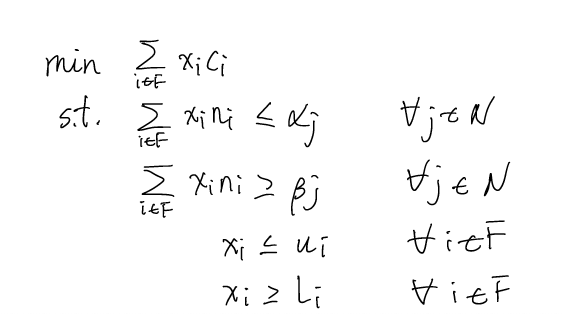

## Data
* FOOD_TB - Cost and min and max amount of each type of food
* AMT_TB - The nutritional value for each type of food
* NUT_TB - The min and max requirement for each type of nutriotional value

In [2]:
food_df = pd.read_csv('https://github.com/georgian-io/constrained_optimization_workshop/raw/main/FOOD_TB.csv', 
                      keep_default_na=False)
amt_df = pd.read_csv('https://github.com/georgian-io/constrained_optimization_workshop/raw/main/AMT_TB.csv', 
                      keep_default_na=False)
nut_df = pd.read_csv('https://github.com/georgian-io/constrained_optimization_workshop/raw/main/NUT_TB.csv', 
                      keep_default_na=False)

In [3]:
food_df

,FOOD,cost,f_min,f_max
0,BEEF,3.19,2,10
1,CHK,2.59,2,10
2,FISH,2.29,2,10
3,HAM,2.89,2,10
4,MCH,1.89,2,10
5,MTL,1.99,2,10
6,SPG,1.99,2,10
7,TUR,2.49,2,10


In [4]:
amt_df

,FOOD,NUT,amt
0,BEEF,A,60
1,BEEF,B1,20
2,BEEF,B2,10
3,BEEF,C,15
4,BEEF,CAL,938
5,BEEF,NA,295
6,CHK,A,8
7,CHK,B1,0
8,CHK,B2,20
9,CHK,C,20


In [5]:
nut_df

,NUT,n_min,n_max
0,A,700,20000
1,B1,700,20000
2,B2,700,20000
3,C,700,20000
4,CAL,0,50000
5,NA,16000,24000


### Data processing

In [7]:
num_food = food_df.shape[0]
num_nut = nut_df.shape[0]

food_types = food_df['FOOD']
nut_types = nut_df['NUT']

food_cost = food_df.set_index(['FOOD'])['cost'].to_dict()
food_min = food_df.set_index(['FOOD'])['f_min'].to_dict()
food_max = food_df.set_index(['FOOD'])['f_max'].to_dict()
nut_min = nut_df.set_index(['NUT'])['n_min'].to_dict()
nut_max = nut_df.set_index(['NUT'])['n_max'].to_dict()

nut_amt = amt_df.set_index(['FOOD', 'NUT'])['amt'].to_dict()

## Solving the Linear Program

### Define Solver

In [6]:
linear_solver = pywraplp.Solver.CreateSolver('GLOP')

### Variables

x_i = amount of food type i in diet

In [9]:
x = {}
for i,food in enumerate(food_types):
  x[food] = linear_solver.NumVar(food_min[food],food_max[food], (str(food)))

### Constraints

In [11]:
# nutritional amount limit
for nut in nut_types:
  linear_solver.Add(linear_solver.Sum([x[food] * nut_amt[food,nut] for food in food_types]) >= nut_min[nut])
  linear_solver.Add(linear_solver.Sum([x[food] * nut_amt[food,nut] for food in food_types]) <= nut_max[nut])

### Objective Function

In [12]:
objective_terms = []
for food in food_types:
  objective_terms.append(x[food] * food_cost[food])

## Solving the Integer Program

5.3 units of beef might be hard to get, what if we restrain the variables to be integers?

### Define Solver

In [27]:
integer_solver = pywraplp.Solver.CreateSolver('SCIP')

## Variables

y_i = number of food type i in diet

In [28]:
y = {}
for i,food in enumerate(food_types):
  y[food] = integer_solver.IntVar(food_min[food],food_max[food], (str(food)))

## Constraints

In [29]:
# nutritional amount limit
for nut in nut_types:
  integer_solver.Add(integer_solver.Sum([y[food] * nut_amt[food,nut] for food in food_types]) >= nut_min[nut])
  integer_solver.Add(integer_solver.Sum([y[food] * nut_amt[food,nut] for food in food_types]) <= nut_max[nut])

## Objective Function

In [31]:
integer_objective_terms = []
for food in food_types:
  integer_objective_terms.append(y[food] * food_cost[food])

## Solve

In [32]:
integer_solver.Minimize(integer_solver.Sum(integer_objective_terms))
status = integer_solver.Solve()

## Print Solution

In [38]:
print('Total Cost: ' + str(integer_solver.Objective().Value()))
print('\nFood Amount\t\tmin\tmax')
for food in food_types:
  print(food + ': ' + str(round(y[food].solution_value(), 4)) + 
        '\t\t' + str(food_min[food]) + 
        '\t' + str(food_max[food]))

print('\nNutritional Values\tmin\tmax')
for nut in nut_types:
  print(nut + ': ' + str(round(sum([y[food].solution_value() * nut_amt[food,nut] for food in food_types]), 4)) +
        '\t\t' + str(nut_min[nut]) + 
        '\t' + str(nut_max[nut]))

Total Cost: 119.3

Food Amount		min	max
BEEF: 9.0		2	10
CHK: 2.0		2	10
FISH: 2.0		2	10
HAM: 8.0		2	10
MCH: 10.0		2	10
MTL: 10.0		2	10
SPG: 7.0		2	10
TUR: 2.0		2	10

Nutritional Values	min	max
A: 2037.0		700	20000
B1: 1560.0		700	20000
B2: 945.0		700	20000
C: 700.0		700	20000
CAL: 49793.0		0	50000
NA: 19155.0		16000	24000
